In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Used to display images in a specific colormap
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)
np.set_printoptions(suppress=True) # Don't print scietific numbers form

# 1 K-means Clustering

1.1 Implementing K-means

In [2]:
data1 = loadmat('ex7/ex7data2.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [3]:
# Select an initial set of centroids
K = 3 # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

1.1.1 Finding closest centroids

In [4]:
def distance(x, p):
    return np.sqrt( (x[0] - p[0])**2 + (x[1] - p[1])**2 )

In [5]:
def find_closest_centroids( X, centroids ):
    K = centroids.shape[0]
    m = X.shape[0]
    dis = np.zeros( (m, K) )
    for i in range(K):
        for j in range(m):
            dis[j][i] = distance( X[j], centroids[i])
    return np.argmin( dis, axis = 1 ) + 1

In [6]:
# Find the closest centroids for the examples using the
# initial_centroids
idx = find_closest_centroids(data1['X'], initial_centroids)
print(idx[0:3])

[1 3 2]


1.1.2 Computing centroid means

In [7]:
def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros( (K, n) )
    for i in range(K):
        p_in_cluster = idx == i+1
        x = X[p_in_cluster]
        centroids[i] = np.mean( x, axis=0 )
    return centroids

In [8]:
compute_centroids(data1['X'], idx, K)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

1.2 K-means on example dataset

In [9]:
def plot_data_points( X, idx, K, axes=None ):
    if axes == None:
        axes = plt.gca()
    color = iter( cm.rainbow( np.linspace( 0, 1, K ) ) )
    for i in range (K):
        p_in_cluster = idx == i+1
        c = next(color)
        axes.scatter( X[p_in_cluster][:,0], X[p_in_cluster][:,1], marker='o', s=30, edgecolors=c,facecolors='None', linewidth=0.7 )

In [10]:
def plot_progress_Kmeans( X, previous, idx, K, i ):
    axes = plt.gca()
    plot_data_points( X, idx, K, axes )
    
    for j in range( previous.shape[1] ):
        c_points = previous[:,2] == j+1
        axes.plot(previous[c_points][:,0], previous[c_points][:,1], 'kx--', markeredgewidth=2, markersize = 6, linewidth=2, label='centroids')
    axes.set_title( f'Iteration number {i+1}' )

In [11]:
def run_Kmeans(X, initial_centroids, max_iters, plot_progress):
    m, n = X.shape
    K = initial_centroids.shape[0]
    previous_centroids = np.c_[ np.copy(initial_centroids), np.arange(1, K + 1) ]
    centroids = np.copy(initial_centroids)
    idx = np.zeros((m, 1))
    
    for i in range(max_iters):
        print(f"K-means iteration {i+1}")
        idx = find_closest_centroids( X, centroids )
        if plot_progress:
            plot_progress_Kmeans( X, previous_centroids, idx, K, i )
                 
        centroids = np.c_[ compute_centroids( X, idx, K ), np.arange(1, K + 1) ]
        previous_centroids = np.concatenate( (previous_centroids, centroids), axis = 0)
    return( centroids[:,:centroids.shape[1]-1], idx )

K-means iteration 1
K-means iteration 2
K-means iteration 3
K-means iteration 4
K-means iteration 5
K-means iteration 6
K-means iteration 7
K-means iteration 8
K-means iteration 9
K-means iteration 10
(3, 2)


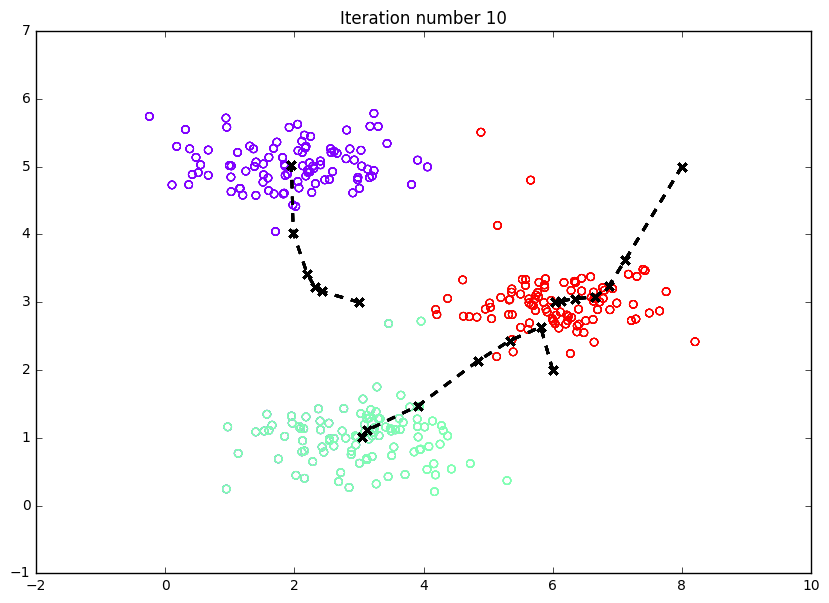

In [12]:
new_centroids, new_idx = run_Kmeans(data1['X'], initial_centroids, 10, True)
print(new_centroids.shape)

In [13]:
print(new_centroids[:,:2])

[[ 1.95399466  5.02557006]
 [ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]]


1.3 Random initialization

In [14]:
def kmeans_init_centroids( X, K ):
    np.random.shuffle(X)
    return X[:K,:]

In [15]:
kmeans_init_centroids( data1['X'], data1['X'].shape[1]+1 )

array([[ 1.16074178,  4.67727927],
       [ 5.6175432 ,  2.5975071 ],
       [ 6.48212628,  2.5508514 ]])

1.4 Image compression with K-means

1.4.1 K-means on pixels

In [16]:
img = plt.imread('ex7/bird_small.png')
img_shape = img.shape
img_shape

(128, 128, 3)

In [17]:
img_X = img.reshape( img_shape[0]*img_shape[1], img_shape[2] )
img_X.shape

(16384, 3)

In [18]:
K_colors = 16
max_iter = 10

In [19]:
# Need to pass a copy of img_X, since shuffle changes the order of the passed array
initial_centroids = kmeans_init_centroids(np.copy(img_X), K_colors)
initial_centroids.shape

(16, 3)

In [20]:
img_centroids, img_idx = run_Kmeans( img_X, initial_centroids, max_iter, False )

K-means iteration 1
K-means iteration 2
K-means iteration 3
K-means iteration 4
K-means iteration 5
K-means iteration 6
K-means iteration 7
K-means iteration 8
K-means iteration 9
K-means iteration 10


In [21]:
print( 'centroids shape = ', img_centroids.shape)
print( 'indices shape = ', img_idx.shape)

centroids shape =  (16, 3)
indices shape =  (16384,)


In [22]:
# Find closest cluster members
img_idx = find_closest_centroids(img_X, img_centroids)
# Essentially, now we have represented the image X as in terms of the indices in idx. 

In [23]:
# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
X_recovered = img_centroids[img_idx - 1,:]

# reshape to the origina l dimensions
X_recovered = X_recovered.reshape( img_shape[0], img_shape[1], img_shape[2])
X_recovered.shape

(128, 128, 3)

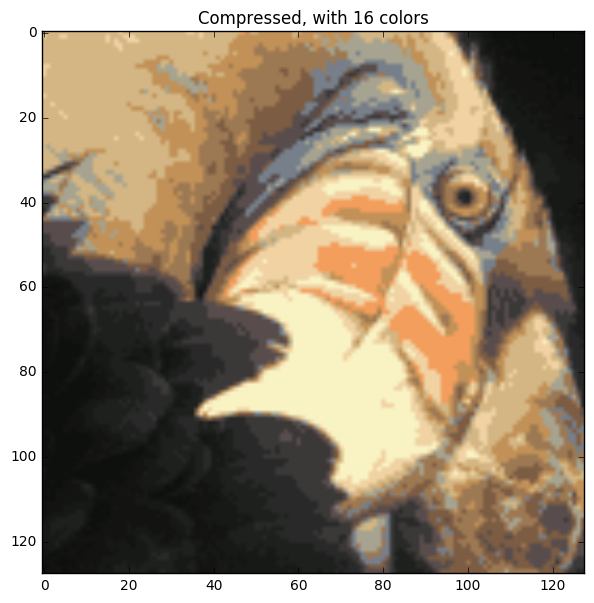

In [24]:
plt.imshow(X_recovered)
plt.title( f'Compressed, with {K_colors} colors' )

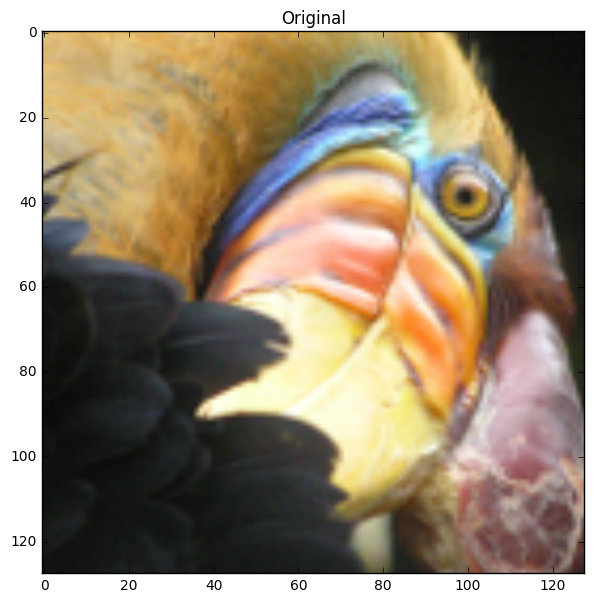

In [25]:
plt.imshow(img)
plt.title( 'Original' )

# 2 Principal Component Analysis

In [26]:
data2 = loadmat('ex7/ex7data1.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [27]:
data2['X'].shape

(50, 2)

2.1 Example Dataset

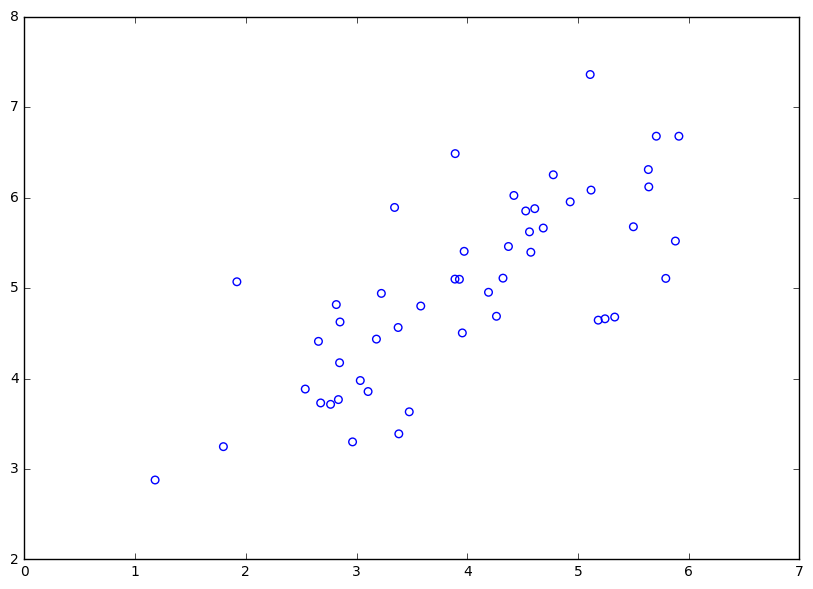

In [28]:
plt.scatter( data2['X'][:,0], data2['X'][:,1], s=30, edgecolors='b',facecolors='None', linewidth=1 )

2.2 Implementing PCA

In [29]:
def feature_normalize( X ):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X - X.mean(axis=0))/X.std(axis=0), mu, sigma

In [30]:
X_norm, mu, sigma = feature_normalize(data2['X'])

In [31]:
def pca(X):
    m, n = X.shape
    cov_data = ( X.T.dot(X) )/m
    U, S, V = np.linalg.svd( cov_data )
    return (U, S)

In [32]:
U, S = pca(X_norm)

In [33]:
print(U, S)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]] [ 1.73553038  0.26446962]


In [34]:
mu

array([ 3.98926528,  5.00280585])

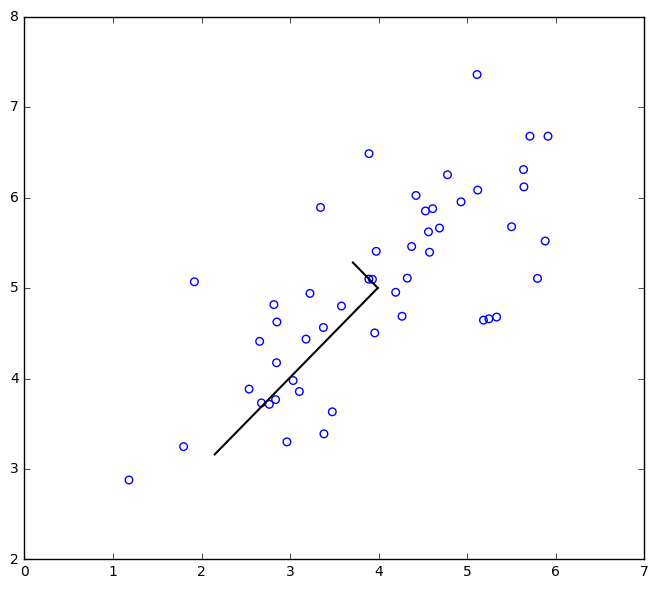

In [35]:
plt.rcParams['figure.figsize'] = (8.0, 7.0) # If the ratio is not set properly, 
# the vectors look as if they were not orthogonal
plt.scatter( data2['X'][:,0], data2['X'][:,1], s=30, edgecolors='b',facecolors='None', linewidth=1 )
plt.plot( np.append( mu[0], mu[0] + 1.5*S[0]*U[0,0] ), np.append( mu[1], mu[1] + 1.5*S[0]*U[1,0] ),'k-', linewidth=1.5 )
plt.plot( np.append( mu[0], mu[0] + 1.5*S[1]*U[0,1] ), np.append( mu[1], mu[1] + 1.5*S[1]*U[1,1] ), 'k-', linewidth=1.5 )

2.3 Dimensionality Reduction with PCA

2.3.1 Projecting the data onto the principal components

In [36]:
def project_data( X, U, K ):
    U_reduce = U[:, :K] # Each column is a u^{i} vector
    return X.dot(U_reduce)

In [37]:
K = 1
Z = project_data(X_norm, U, K)
Z[0]

array([ 1.49631261])

2.3.2 Reconstructing an approximation of the data

In [38]:
def recover_data( Z, U, K ):
    U_reduce = U[:, :K] # Each column is a u^{i} vector
    return U_reduce.dot(Z.T)

In [39]:
X_approx = recover_data( Z, U, K )
X_approx = X_approx.T

In [40]:
X_approx[0]

array([-1.05805279, -1.05805279])

2.3.3 Visualizing the projections

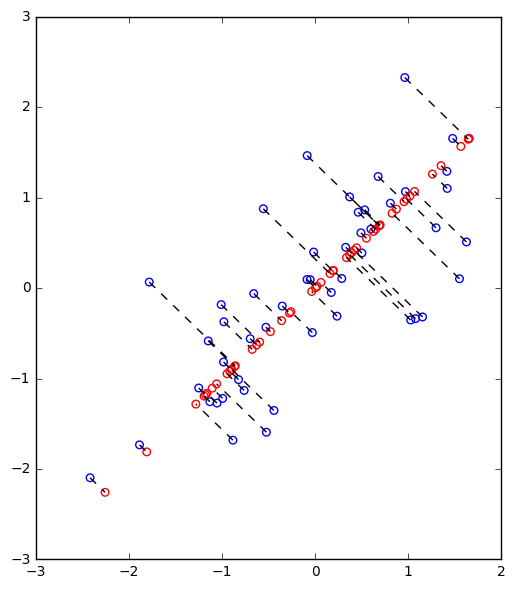

In [41]:
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.scatter( X_norm[:,0], X_norm[:,1], s=30, edgecolors='b',facecolors='None', linewidth=1 )
plt.scatter( X_approx[:,0], X_approx[:,1], s=30, edgecolors='r',facecolors='None', linewidth=1 )
for i in range(X_approx.shape[0]):
    plt.plot( (X_norm[i,0], X_approx[i,0]), (X_norm[i,1], X_approx[i,1]), 'k--' )

2.4 Face Image Dataset

In [42]:
faces = loadmat('ex7/ex7faces.mat')
faces.keys()
faces['X'].shape

(5000, 1024)

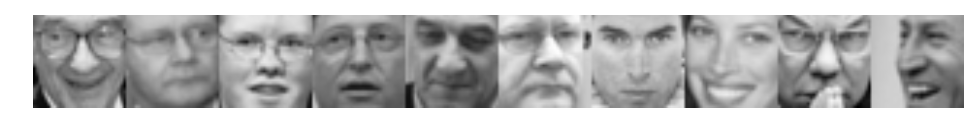

In [43]:
plt.rcParams['figure.figsize'] = (12,4)
sample = np.arange(10)
data_plot = faces['X'][sample,:].reshape( -1, 32 ).T # Make a 10X32X32 array and rotate
img = plt.imshow(data_plot, cmap = cm.Greys_r)
plt.axis('off');

2.4.1 PCA on Faces

In [44]:
X_norm_f, mu_f, sigma_f = feature_normalize( faces['X'] ) 

In [45]:
U_f, S_f = pca( X_norm_f )

In [46]:
U_f.shape

(1024, 1024)

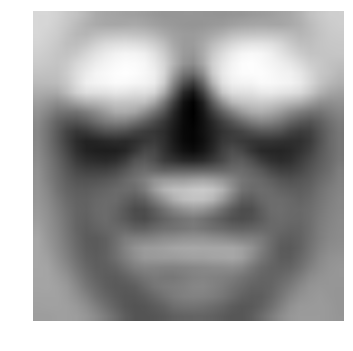

In [47]:
plt.rcParams['figure.figsize'] = (4,4)
sample = np.arange(2)
data_plot = U_f[:,5].reshape( -1, 32).T
img = plt.imshow(data_plot, cmap = cm.Greys_r)
plt.axis('off');

2.4.2 Dimensionality Reduction

In [48]:
# Project each image onto a 36D space
Z_f = project_data( X_norm_f, U_f, K=36 )

In [49]:
# Approximate back the original dimensionality
X_approx_f = recover_data( Z_f, U_f, K=36 )

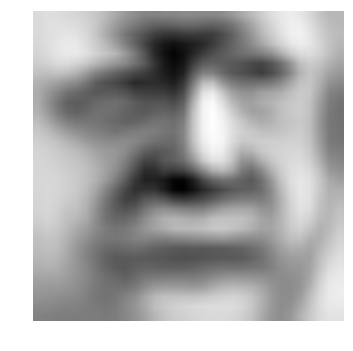

In [50]:
plt.rcParams['figure.figsize'] = (4,4)
sample = np.arange(2)
data_plot = X_approx_f[:,5].reshape( -1, 32).T
img = plt.imshow(data_plot, cmap = cm.Greys_r)
plt.axis('off');

2.5 Optional (ungraded) exercise: PCA for visualiza- tion

In [51]:
# Normalize the bird image data
img_X_norm, mu_img, sigma_img = feature_normalize( img_X )

In [52]:
U_img, S_img = pca( img_X_norm )

In [53]:
# Project the data to 2D
Z_img = project_data( img_X_norm, U_img, 2 )

In [54]:
Z_img.shape

(16384, 2)

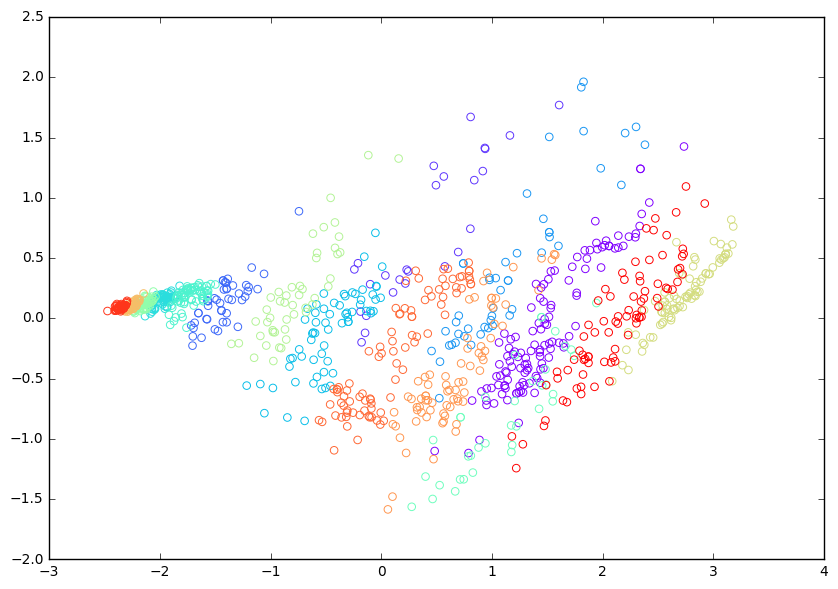

In [55]:
plt.rcParams['figure.figsize'] = (10.0, 7.0)
sample = np.random.choice( 16384, 1000 )
plot_data_points( -1*Z_img[sample,:], img_idx[sample], 16 )